In [46]:
import numpy as np
import scipy as sp
from scipy import special
#import decimal as dc
#dc.getcontext().prec = 50

import mpmath
mpmath.mp.dps = 50

############################################
import matplotlib.pyplot as plt            #
plt.rcParams['figure.figsize'] = (15, 6)   #
############################################

In [47]:
def is_even(x):
    return x % 2 == 0

In [48]:
#def bernoulli_num(n):
#    B = np.zeros(n+1)
#    B[0] = 1.0
#    for i in range(1, n+1):
#        sum = 0.0
#        for k in range(i):
#            sum += 1.0*sp.special.binom(i+1, k)*(B[k]
#        B[i]=-sum/(i+1.0)
#    return B[n]

#print(bernoulli_num(14))

In [49]:
#def bernoulli_num(n):
#    B = np.zeros(n+1, dtype=np.dtype(mpmath.mpf))
#    B[0] = mpmath.mpf(1.0)
#    for i in range(1, n+1):
#        sum = mpmath.mpf(0.0)
#        for k in range(i):
#            sum += mpmath.mpf(1.0*sp.special.binom(i+1, k))*mpmath.mpf(B[k])
#        B[i]=-sum/mpmath.mpf(i+1.0)
#    return B[n]

#print(bernoulli_num(14))

In [50]:
#def custom_gammaln(x, d=20):
#    if x>0:
#        loggamma = dc.Decimal(x-0.5)*dc.Decimal(1.0*x).ln() - dc.Decimal(x) + dc.Decimal(0.5)*dc.Decimal(2*np.pi).ln()
#        for m in range(1, d+1):
#            summand = dc.Decimal(1.0)*bernoulli_num(2*m)/(dc.Decimal(2.0*m)*(dc.Decimal(2.0*m - 1.0)) * dc.Decimal(1.0*x)**dc.Decimal((2.0*m - 1.0)))
#            loggamma += summand
#        return loggamma
#    elif x == 0:
#        return np.inf
#    else:
#        print('No gamma of negative allowed here!')

In [51]:
#test_val = 6
#print(custom_gammaln(test_val))
#print(sp.special.gammaln(test_val))

#lpl = []
#iss = []
#for i in range(5,25):
#    lpl.append(float(custom_gammaln(test_val, i)))
#    iss.append(i)

#plt.plot(iss, lpl, label = 'custom gammaln')
#plt.xlabel('degree of approximation')
#plt.ylabel('gammaln({})'.format(test_val))
#plt.plot(iss, np.full(len(iss),sp.special.gammaln(test_val)), label = 'scipy gammaln')
#plt.grid(True)
#plt.legend(loc = 'best')
#plt.savefig('gammaln.pdf')
#plt.show()

In [52]:
#def logbinomial(a, b):
#    return sp.special.gammaln(a + 1) - sp.special.gammaln(b + 1) - sp.special.gammaln(a - b + 1)

In [53]:
def logbinomial(a, b):
    return mpmath.loggamma(a + 1) - mpmath.loggamma(b + 1) - mpmath.loggamma(a - b + 1)

In [54]:
#a = 0.0
#def pdf_beta(p, s, f):
#    return np.exp((s - 1 + a) * np.log(p) + (f - 1 + a) * np.log(1 - p) - sp.special.betaln(s + a, f + a))

In [71]:
a = 0.0
def pdf_beta(p, s, f):
    def calc(p, s, f):
        return mpmath.exp((s - 1 + a) * mpmath.log(p) + mpmath.mpf(f - 1 + a) * mpmath.log(1 - p) - mpmath.log(mpmath.beta(s + a, f + a)))
    if isinstance(p, int) or isinstance(p, float):
        result = calc(p, s, f)
    else:
        result = np.zeros(len(p))
        for i in range(len(p)):
            pi = p[i]
            result[i] = calc(pi, s, f)
    return result

aasa = np.array([0.1,0.2,0.3])
print(pdf_beta(0.4,4,5))
print(pdf_beta(aasa,4,5))

2.322432000000000042973624658770842542877953984747
[ 0.183708  0.917504  1.815156]


In [56]:
#def custom_logsumexp(ns):
#    tmax = max(ns)
#    result = dc.Decimal(tmax) + dc.Decimal(sum([(dc.Decimal(i) - dc.Decimal(tmax)).exp() for i in ns])).ln()
#    return result

#al = [0.0, 4.8848981731984509, 7.8241012314455247, 9.6741296087975286, 10.704533647439149, 11.037382691690851, 10.729301060372364, 9.7964471384604792, 8.2206371424561837, 5.9432008100282303, 2.8399812234746662, -1.3607233547384965, -7.5176724998214297]
#bl = [2.8071942514172008, 6.5186945294646819, 8.8631993925812367, 10.282118981017135, 10.953501207710218, 10.961633037740995, 10.341291609075626, 9.0914655002535767, 7.1753444913208284, 4.5065775497486982, 0.9050001449514582, -4.0729900062196123]

#print(sp.special.logsumexp(al, b = 1))
#print(sp.special.logsumexp(bl, b = 1))
#print(custom_logsumexp(al))
#print(custom_logsumexp(bl))
#if custom_logsumexp(al)<custom_logsumexp(bl):
#    print('Even partsum should not be smaller than odd partsum!')
#else:
#    print('Everything fine!')

In [57]:
#def custom_logsumexp(ns):
#    tmax = max(ns)
#    result = mpmath.mpf(tmax) + mpmath.log(sum([mpmath.exp(mpmath.mpf(i) - mpmath.mpf(tmax)) for i in ns]))
#    return result

#al = [0.0, 4.8848981731984509, 7.8241012314455247, 9.6741296087975286, 10.704533647439149, 11.037382691690851, 10.729301060372364, 9.7964471384604792, 8.2206371424561837, 5.9432008100282303, 2.8399812234746662, -1.3607233547384965, -7.5176724998214297]
#bl = [2.8071942514172008, 6.5186945294646819, 8.8631993925812367, 10.282118981017135, 10.953501207710218, 10.961633037740995, 10.341291609075626, 9.0914655002535767, 7.1753444913208284, 4.5065775497486982, 0.9050001449514582, -4.0729900062196123]

#print(sp.special.logsumexp(al, b = 1))
#print(sp.special.logsumexp(bl, b = 1))
#print(custom_logsumexp(al))
#print(custom_logsumexp(bl))
#if custom_logsumexp(al)<custom_logsumexp(bl):
#    print('Even partsum should not be smaller than odd partsum!')
#else:
#    print('Everything fine!')

In [58]:
def custom_logsumexp_mpmath(logs, signs):
    positive_mask=signs>0
    #print type(positive_mask)
    #print np.array(logs)
    positive_logs=np.array(logs)[positive_mask]
    negative_logs=np.array(logs)[positive_mask==False]

    res_pos=mpmath.mpf(0.0)
    res_neg=None

    if(len(positive_logs)>0):
        #print(type([mpmath.exp(i-max(positive_logs)) for i in positive_logs]))
        res_pos = max(positive_logs) + mpmath.log(sum([mpmath.exp(i-max(positive_logs)) for i in positive_logs]))
        
    if(len(negative_logs)>0):
        res_neg = max(negative_logs) + mpmath.log(sum([mpmath.exp(i-max(negative_logs)) for i in negative_logs]))
    
    #print "repos/resneg", res_pos, res_neg
    
    if(res_neg is None):
        
        return res_pos, 1.0
   
    if(res_pos==res_neg):
        print("not enough precision!!!...")
        exit(-1)
        return None, None
    elif(res_pos==res_neg and res_pos==0):
        print("0?!")
        print(logs)
        exit(-1)
    if(res_neg<res_pos):
        #print("neg < pos")
        ## easy case .. subtracted number is smaller 
        return res_neg + mpmath.log(mpmath.exp(res_pos-res_neg) - 1), 1.0
    else:
        ## A-B < 0 -> A-B = - (B-A) 
        return res_pos + mpmath.log(mpmath.exp(res_neg-res_pos) - 1), -1.0

In [59]:
#def log_hyper_2F1_below_1(a1, a2, b1, b2, w):
#    log_results_even = []
#    log_results_odd = []
#    for n in range(int(b1)):
#        log_resu = logbinomial(b1 - 1 +a, n) + sp.special.gammaln(a1 + a2 + n +2*a) + sp.special.gammaln(a1 + a2 + b2 + 3*a) - sp.special.gammaln(a1 + a2 + b2 + n + 3*a) - sp.special.gammaln(a1 + a2 + 2*a) + n * np.log(w)
#        if is_even(n):
#            log_results_even.append(log_resu)
#        else:
#            log_results_odd.append(log_resu)
#    if len(log_results_odd) == 0:
#        log_results_odd_partsum = -np.inf
#    else:
#        log_results_odd_partsum = sp.special.logsumexp(log_results_odd)
#    if len(log_results_even) == 0:
#        log_results_even_partsum = -np.inf
#    else:
#        log_results_even_partsum = sp.special.logsumexp(log_results_even)
#    if log_results_odd_partsum > log_results_even_partsum:
#        print('Dang!')
#    log_result = sp.special.logsumexp([log_results_even_partsum, log_results_odd_partsum], b=[1,-1])
#    return log_result

#def log_hyper_2F1_above_1(a1, a2, b1, b2, w):
#    log_results_even = []
#    log_results_odd = []
#    for n in range(int(b2)):
#        log_resu = logbinomial(b2 - 1 +a, n) + sp.special.gammaln(a1 + a2 + n + 2*a) + sp.special.gammaln(a1 + a2 + b1 + 3*a) - sp.special.gammaln(a1 + a2 + b1 + n + 3*a) - sp.special.gammaln(a1 + a2 + 2*a) - n * np.log(w)
#        if is_even(n):
#            log_results_even.append(log_resu)
#        else:
#            log_results_odd.append(log_resu)
    #print(log_results_even)
    #print(log_results_odd)
#    if len(log_results_odd) == 0:
#        log_results_odd_partsum = -np.inf
#    else:
#        log_results_odd_partsum = sp.special.logsumexp(log_results_odd)
#    if len(log_results_even) == 0:
#        log_results_even_partsum = -np.inf
#    else:
#        log_results_even_partsum = sp.special.logsumexp(log_results_even)
#    if log_results_odd_partsum > log_results_even_partsum:
#        print('Dang!!!')
#    log_result = sp.special.logsumexp([log_results_even_partsum, log_results_odd_partsum], b=[1,-1])
#    return log_result

In [60]:
def log_hyper_2F1_below_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b1)):
        log_resu = logbinomial(b1 - 1 +a, n) + mpmath.loggamma(a1 + a2 + n +2*a) + mpmath.loggamma(a1 + a2 + b2 + 3*a) - mpmath.loggamma(a1 + a2 + b2 + n + 3*a) - mpmath.loggamma(a1 + a2 + 2*a) + n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            #log_results_odd_partsum = -np.inf
            return log_results_even_partsum
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1,-1]))
            return log_result[0]

def log_hyper_2F1_above_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b2)):
        log_resu = logbinomial(b2 - 1 +a, n) + mpmath.loggamma(a1 + a2 + n + 2*a) + mpmath.loggamma(a1 + a2 + b1 + 3*a) - mpmath.loggamma(a1 + a2 + b1 + n + 3*a) - mpmath.loggamma(a1 + a2 + 2*a) - n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    #print(log_results_even)
    #print(log_results_odd)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            return log_results_even_partsum
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!!!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1,-1]))
            return log_result[0]

In [61]:
#def pdf_bb_ratio(a1, a2, b1, b2, w):
#    lnA = sp.special.betaln(a1, b1) + sp.special.betaln(a2, b2)
#    def pdf_calc(wi):
#        if wi < 0:
#            print('Ratio below Zero! Not reasonable!')
#            exit(1)
#        elif wi == 0:
#            resulti = 0
#        elif wi < 1:
#            resulti = np.exp(sp.special.betaln(a1 + a2, b2) + (a1 - 1) * np.log(wi) + log_hyper_2F1_below_1(a1, a2, b1, b2, wi) - lnA)
#        else:
#            resulti = np.exp(sp.special.betaln(a1 + a2, b1) - (1 + a2) * np.log(wi) + log_hyper_2F1_above_1(a1, a2, b1, b2, wi) - lnA)
#        return resulti
#    if isinstance(w, int) or isinstance(w, float):
#        result = pdf_calc(w)
#    else:
#        result = np.zeros(len(w))
#        for i in range(len(w)):
#            wi = w[i]
#            result[i] = pdf_calc(wi)
#    return result

In [62]:
def pdf_bb_ratio(a1, a2, b1, b2, w):
    lnA = mpmath.log(mpmath.beta(a1, b1)) + mpmath.log(mpmath.beta(a2, b2))
    def pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(1)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b2)) + (a1 - 1.0) * mpmath.log(wi) + log_hyper_2F1_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b1)) - (1.0 + a2) * mpmath.log(wi) + log_hyper_2F1_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(w, int) or isinstance(w, float):
        result = pdf_calc(w)
    else:
        result = np.zeros(len(w))
        for i in range(len(w)):
            wi = w[i]
            result[i] = pdf_calc(wi)
    return result

In [63]:
#def log_hyper_3F2_below_1(a1, a2, b1, b2, w):
#    log_results_even = []
#    log_results_odd = []
#    for n in range(int(b1)):
#        log_resu = logbinomial(b1 - 1, n) + sp.special.gammaln(a1 + n) + sp.special.gammaln(a1 + a2 + n) + sp.special.gammaln(a1 + 1) + sp.special.gammaln(a1 + a2 + b2) - sp.special.gammaln(a1) - sp.special.gammaln(a1 + a2) - sp.special.gammaln(a1 + n + 1) - sp.special.gammaln(a1 + a2 + b2 + n) + n * np.log(w)
#        if is_even(n):
#            log_results_even.append(log_resu)
#        else:
#            log_results_odd.append(log_resu)
#    if len(log_results_odd) == 0:
#        log_results_odd_partsum = -np.inf
#    else:
#        log_results_odd_partsum = sp.special.logsumexp(log_results_odd)
#    if len(log_results_even) == 0:
#        log_results_even_partsum = -np.inf
#    else:
#        log_results_even_partsum = sp.special.logsumexp(log_results_even)
#    log_result = sp.special.logsumexp([log_results_even_partsum, log_results_odd_partsum], b = [1, -1])
#    return log_result

#def log_hyper_3F2_above_1(a1, a2, b1, b2, w):
#    log_results_even = []
#    log_results_odd = []
#    for n in range(int(b2)):
#        log_resu = logbinomial(b2 - 1, n) + sp.special.gammaln(a2 + n) + sp.special.gammaln(a1 + a2 + n) + sp.special.gammaln(a2 + 1) + sp.special.gammaln(a1 + a2 + b1) - sp.special.gammaln(a2) - sp.special.gammaln(a1 + a2) - sp.special.gammaln(a2 + n + 1) - sp.special.gammaln(a1 + a2 + b1 + n) - n * np.log(w)
#        if is_even(n):
#            log_results_even.append(log_resu)
#        else:
#            log_results_odd.append(log_resu)
#    if len(log_results_odd) == 0:
#        log_results_odd_partsum = -np.inf
#    else:
#        log_results_odd_partsum = sp.special.logsumexp(log_results_odd)
#    if len(log_results_even) == 0:
#        log_results_even_partsum = -np.inf
#    else:
#        log_results_even_partsum = sp.special.logsumexp(log_results_even)
#    log_result = sp.special.logsumexp([log_results_even_partsum, log_results_odd_partsum], b = [1, -1])
#    return log_result

In [64]:
def log_hyper_3F2_below_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b1)):
        log_resu = logbinomial(b1 - 1, n) + mpmath.loggamma(a1 + n) + mpmath.loggamma(a1 + a2 + n) + mpmath.loggamma(a1 + 1) + mpmath.loggamma(a1 + a2 + b2) - mpmath.loggamma(a1) - mpmath.loggamma(a1 + a2) - mpmath.loggamma(a1 + n + 1) - mpmath.loggamma(a1 + a2 + b2 + n) + n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            return log_results_even_partsum
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!!!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1, -1]))
            return log_result[0]

def log_hyper_3F2_above_1(a1, a2, b1, b2, w):
    log_results_even = []
    log_results_odd = []
    for n in range(int(b2)):
        log_resu = logbinomial(b2 - 1, n) + mpmath.loggamma(a2 + n) + mpmath.loggamma(a1 + a2 + n) + mpmath.loggamma(a2 + 1) + mpmath.loggamma(a1 + a2 + b1) - mpmath.loggamma(a2) - mpmath.loggamma(a1 + a2) - mpmath.loggamma(a2 + n + 1) - mpmath.loggamma(a1 + a2 + b1 + n) - n * mpmath.log(w)
        if is_even(n):
            log_results_even.append(log_resu)
        else:
            log_results_odd.append(log_resu)
    if len(log_results_even) == 0:
        return -np.inf
    else:
        log_results_even_partsum = custom_logsumexp_mpmath(log_results_even, np.ones(len(log_results_even)))
        if len(log_results_odd) == 0:
            return log_results_even_partsum
        else:
            log_results_odd_partsum = custom_logsumexp_mpmath(log_results_odd, np.ones(len(log_results_odd)))
            if log_results_odd_partsum[0] > log_results_even_partsum[0]:
                print('Dang!!!')
            log_result = custom_logsumexp_mpmath([log_results_even_partsum[0], log_results_odd_partsum[0]], np.array([1, -1]))
            return log_result[0]

In [65]:
#def cdf_bb_ratio(a1, a2, b1, b2, w):
#    lnA = sp.special.betaln(a1, b1) + sp.special.betaln(a2, b2)
#    def cum_pdf_calc(wi):
#        if wi < 0:
#            print('Ratio below Zero! Not reasonable!')
#            exit(1)
#        elif wi == 0:
#            resulti = 0
#        elif wi < 1:
#            resulti = np.exp(sp.special.betaln(a1 + a2, b2) + a1 * np.log(wi) - np.log(a1) + log_hyper_3F2_below_1(a1, a2, b1, b2, wi) - lnA)
#        else:
#            resulti = 1 - np.exp(sp.special.betaln(a1 + a2, b1) - a2 * np.log(wi) - np.log(a2) + log_hyper_3F2_above_1(a1, a2, b1, b2, wi) - lnA)
#        return resulti
#    if isinstance(w, int) or isinstance(w, float):
#        result = cum_pdf_calc(w)
#    else:
#        result = np.zeros(len(w))
#        for i in range(len(w)):
#            wi = w[i]
#            result[i] = cum_pdf_calc(wi)
#    return result

In [66]:
def cdf_bb_ratio(a1, a2, b1, b2, w):
    lnA = mpmath.log(mpmath.beta(a1, b1)) + mpmath.log(mpmath.beta(a2, b2))
    def cum_pdf_calc(wi):
        if wi < 0:
            print('Ratio below Zero! Not reasonable!')
            exit(1)
        elif wi == 0:
            resulti = 0
        elif wi < 1:
            resulti = mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b2)) + a1 * mpmath.log(wi) - mpmath.log(a1) + log_hyper_3F2_below_1(a1, a2, b1, b2, wi) - lnA)
        else:
            resulti = 1 - mpmath.exp(mpmath.log(mpmath.beta(a1 + a2, b1)) - a2 * mpmath.log(wi) - mpmath.log(a2) + log_hyper_3F2_above_1(a1, a2, b1, b2, wi) - lnA)
        return resulti
    if isinstance(w, int) or isinstance(w, float):
        result = cum_pdf_calc(w)
    else:
        result = np.zeros(len(w))
        for i in range(len(w)):
            wi = w[i]
            result[i] = cum_pdf_calc(wi)
    return result

Expectation value of fraction a/b: $E(\frac{a}{b}) = E(a)\cdot E(b^{-1})$

with $E(a) = \frac{a_1}{a_1+b_1}$

and $E(b^{-1}) = \int_{-\infty}^{\infty}\frac{b^{a_2-2} (1-b)^{b_2-1}}{B(a_2-1, b_2) \left(\frac{a_2-1}{a_2+b_2-1}\right)}\,\mathrm{d}b = \frac{a_2+b_2-1}{a_2-1}$

$\Rightarrow E(\frac{a}{b}) = \frac{a_1\cdot(a_2+b_2-1)}{(a_1+b_1)\cdot(a_2-1)}$

In [67]:
#v = np.linspace(0,1.75,1751)
#a1 = 9
#b1 = 9
#a2 = 26
#b2 = 14
#pdf1 = pdf_beta(v, a1, b1)
#pdf2 = pdf_beta(v, a2, b2)
#ratio_pdf = pdf_bb_ratio(a1, a2, b1, b2, v)
#ratio_cdf = cdf_bb_ratio(a1, a2, b1, b2, v)
#plt.plot(v, pdf1, label = 'PDF 1 (a1 = {}, b1 = {})'.format(a1, b1))
#plt.plot(v, pdf2, label = 'PDF 2 (a2 = {}, b2 = {})'.format(a2, b2))
#plt.plot(v, ratio_pdf, label = 'ratio PDF')
#plt.plot(v, ratio_cdf, label = 'ratio CDF')

#expect_value = (a1*(a2+b2-1))/((a1+b1)*(a2-1))

#plt.axvline(x = (a1/(a1+b1))/(a2/(a2+b2)), linewidth = 1.25, color = 'purple', linestyle = '-.', label = 'Naive ({})'.format((a1/(a1+b1))/(a2/(a2+b2))), alpha = .5)
#plt.axvline(x = expect_value, linewidth = 1.5, color = 'green', linestyle = '--', label = 'Expectation value ({})'.format(expect_value))

#plt.grid(True)
#plt.legend(loc = 'best', fontsize = 'large')
#plt.show()

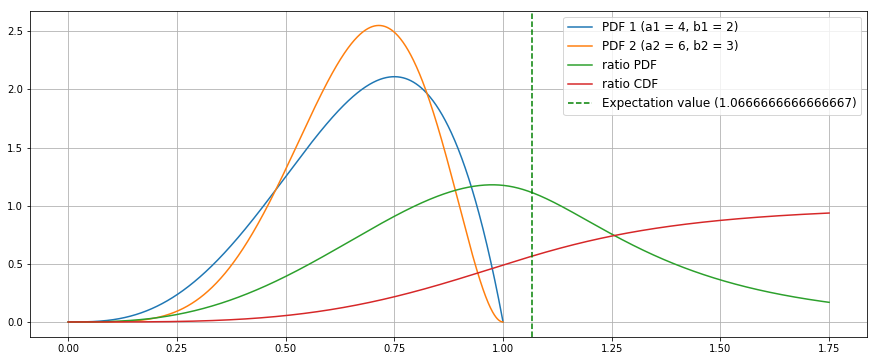

In [85]:
u = np.linspace(0, 1, 1001)
v = np.linspace(0,1.75,1751)

a1 = 4
b1 = 2
a2 = 6
b2 = 3

pdf1 = pdf_beta(u, a1, b1)
pdf2 = pdf_beta(u, a2, b2)
ratio_pdf = pdf_bb_ratio(a1, a2, b1, b2, v)
ratio_cdf = cdf_bb_ratio(a1, a2, b1, b2, v)
plt.plot(u, pdf1, label = 'PDF 1 (a1 = {}, b1 = {})'.format(a1, b1))
plt.plot(u, pdf2, label = 'PDF 2 (a2 = {}, b2 = {})'.format(a2, b2))
plt.plot(v, ratio_pdf, label = 'ratio PDF')
plt.plot(v, ratio_cdf, label = 'ratio CDF')

expect_value = (a1*(a2+b2-1))/((a1+b1)*(a2-1))

#plt.axvline(x = (a1/(a1+b1))/(a2/(a2+b2)), linewidth = 1.25, color = 'purple', linestyle = '-.', label = 'Naive ({})'.format((a1/(a1+b1))/(a2/(a2+b2))), alpha = .5)
plt.axvline(x = expect_value, linewidth = 1.5, color = 'green', linestyle = '--', label = 'Expectation value ({})'.format(expect_value))

plt.grid(True)
plt.legend(loc = 'best', fontsize = 'large')
#plt.savefig('beta_beta_pdf_cdf.pdf')
plt.show()